# Import modules

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

# Sales

## Import

In [2]:
import pandas as pd
import numpy as np

#read in sales data, already subsetted to include Manhattan only
sales17 = pd.read_csv("INPUT_nycod/2017_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales18 = pd.read_csv("INPUT_nycod/2018_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales19 = pd.read_csv("INPUT_nycod/2019_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales20 = pd.read_csv("INPUT_nycod/2020_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales21 = pd.read_csv("INPUT_nycod/2021_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales22 = pd.read_csv("INPUT_nycod/rollingsales_manhattan.csv", skiprows=1, header=None).dropna(how='all')

#concatenate all dfs, check shape
allsales = pd.concat((sales17, sales18, sales19, sales20, sales21, sales22), axis=0)
allsales = allsales.iloc[:,0:21]
print(allsales.shape)

#add labels
labels = pd.DataFrame(pd.read_csv("INPUT_nycod/2021_manhattan.csv", header=6).columns).T
allsales = pd.concat((labels, allsales), axis=0)
allsales.columns = allsales.iloc[0] 
sales = allsales[1:]
sales.columns

(110226, 21)


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS',
       'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object', name=0)

## Select cols for subsetting

In [3]:
sales = sales[['BLOCK',
                'LOT',
                'ADDRESS',
                'RESIDENTIAL\nUNITS',
                'COMMERCIAL\nUNITS',
                'LAND \nSQUARE FEET',
                'GROSS \nSQUARE FEET',
                'YEAR BUILT',
                'SALE DATE',
                'SALE PRICE']]

#rename columns for interpretability
col_mapper = {'RESIDENTIAL\nUNITS':'units_residential',
             'COMMERCIAL\nUNITS':'units_commercial',
             'BLOCK': 'block_sales',
             'LOT': 'lot_sales',
             'ADDRESS': 'address_sales'}
sales = sales.rename(mapper=col_mapper, axis=1)

## Dtype handling

In [4]:
len(sales[sales['GROSS \nSQUARE FEET'].isna() == True])

53778

In [5]:
sales.dtypes

0
block_sales            object
lot_sales              object
address_sales          object
units_residential      object
units_commercial       object
LAND \nSQUARE FEET     object
GROSS \nSQUARE FEET    object
YEAR BUILT             object
SALE DATE              object
SALE PRICE             object
dtype: object

In [6]:
#clean sale price
prices = []
for i in sales['SALE PRICE']:
    prices.append(float(i.replace(",", "").replace("'", "").replace("$", "")))
sales['saleprice'] = prices

#clean sale date -> year sold, years elapsed
import datetime
dates = []
for i in sales['SALE DATE']:
    dates.append(datetime.datetime.strptime(i, "%m/%d/%Y"))
sales['saledate'] = dates
years = []
for i in sales['SALE DATE']:
    years.append(int(i[-4:]))
sales['year_sold'] = years
sales['years_elapsed'] = sales.year_sold - sales['YEAR BUILT']

#calculate FAR
gross_sqft = []
for i in sales['GROSS \nSQUARE FEET']:
    try:
        gross_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        gross_sqft.append(0)
sales['gross_sqft'] = gross_sqft
land_sqft = []
for i in sales['LAND \nSQUARE FEET']:
    try:
        land_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        land_sqft.append(0)
sales['land_sqft'] = land_sqft
sales['FAR'] = sales['gross_sqft'] / sales['land_sqft']

#change dtypes
sales.block_sales = sales.block_sales.astype(np.int64)
sales.lot_sales = sales.lot_sales.astype(np.int64)
sales.units_commercial = pd.to_numeric(sales.units_commercial.replace(',',''), errors='coerce')
sales.units_residential = pd.to_numeric(sales.units_residential.replace(',',''), errors='coerce')

#drop columns only used for calc
sales = sales.drop(columns=['SALE PRICE',
                           'YEAR BUILT',
                           'SALE DATE',
                           'GROSS \nSQUARE FEET',
                           'LAND \nSQUARE FEET',
                           'gross_sqft',
                           'land_sqft',
                           'saledate'])
sales.columns

Index(['block_sales', 'lot_sales', 'address_sales', 'units_residential',
       'units_commercial', 'saleprice', 'year_sold', 'years_elapsed', 'FAR'],
      dtype='object', name=0)

## Visualize rows to be dropped: sale price == 0, res units == NaN

total observations: 110226
non-sale transfers (sale price 0): 21787
sales (sale price > 0): 88439


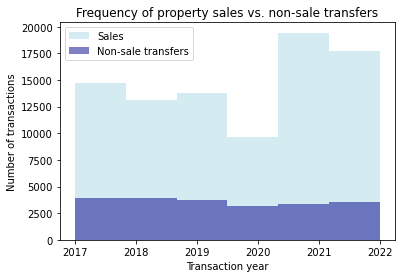

In [7]:
#FOR VIZ ONLY
#missing sale price
print("total observations: {}".format(len(sales)))
print("non-sale transfers (sale price 0): {}".format(len(sales[sales['saleprice'] == 0])))
print("sales (sale price > 0): {}".format(len(sales[sales['saleprice'] > 0])))

import matplotlib.pyplot as plt
plt.hist(sales[sales.saleprice > 0].year_sold, alpha=0.5, color='lightblue', label='Sales', bins=6)
plt.hist(sales[sales.saleprice == 0].year_sold, alpha=0.5, color='darkblue', label='Non-sale transfers', bins=6)
plt.legend()
plt.title('Frequency of property sales vs. non-sale transfers')
plt.xlabel('Transaction year')
plt.ylabel('Number of transactions')
plt.savefig('OUTPUT_visualizations/1.Sales vs. non-sale transfers.png')
plt.show()

In [8]:
#SUBSET DATA
sales = sales[sales['saleprice'] > 0]

#after removing zeros
sales['log_saleprice'] = np.log(sales.saleprice)
sales = sales.drop(columns=['saleprice'])

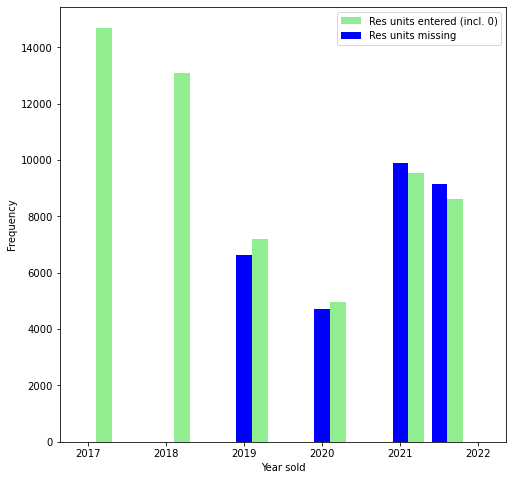

In [9]:
#FOR VIZ ONLY
#dates of missing and nonmissing residential units

a = sales[sales['units_residential']>=-1]
b = sales[sales['units_residential'].isna() == True]

plt.figure(figsize=(8,8))
plt.hist(a.year_sold+0.1, label='Res units entered (incl. 0)', color='lightgreen', width=0.2)
plt.hist(b.year_sold-0.1, label='Res units missing', color='blue', width=0.2)
plt.xlabel('Year sold')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('OUTPUT_visualizations/resunitsmissing.png')
plt.show()

# PLUTO

## Import

In [10]:
pluto = pd.read_csv("INPUT_pluto/pluto_22v3_1.csv", low_memory=False)
pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

## Select cols for subsetting

In [11]:
#subset to include Manhattan only
pluto = pluto[pluto['borough']=='MN']
pluto = pluto[['block',
              'lot',
               'address',
               'ltdheight',
              'splitzone',
              'histdist',
              'landmark',
              'bldgarea',
              'lotarea',
              'latitude',
              'longitude',
              'yearalter1',
              'yearalter2',
              'numbldgs',
              'numfloors']]

#rename columns for interpretability
col_mapper = {'block': 'block_pluto',
             'lot': 'lot_pluto',
             'address': 'address_pluto'}
pluto = pluto.rename(mapper=col_mapper, axis=1)

## Dtype handling

In [12]:
#create BCR variable
pluto['BCR'] = pluto['bldgarea'] / pluto['lotarea']

#create binary variables
bin_cols = ['ltdheight', 'splitzone', 'histdist', 'landmark']
pluto['bin_ltdheight'] = abs(1-(pluto.ltdheight.isna()))
pluto['bin_splitzone'] = abs(1-(pluto.splitzone.isna()))
pluto['bin_histdist'] = abs(1-(pluto.histdist.isna()))
pluto['bin_landmark'] = abs(1-(pluto.landmark.isna()))

#drop cols only used for calc
pluto = pluto.drop(columns=['bldgarea',
                           'lotarea',
                           'ltdheight',
                           'histdist',
                           'landmark',
                           'splitzone'])
pluto.columns

Index(['block_pluto', 'lot_pluto', 'address_pluto', 'latitude', 'longitude',
       'yearalter1', 'yearalter2', 'numbldgs', 'numfloors', 'BCR',
       'bin_ltdheight', 'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

# Merge sales and pluto

In [13]:
pluto = pluto[pluto.block_pluto < pluto.block_pluto.max()]

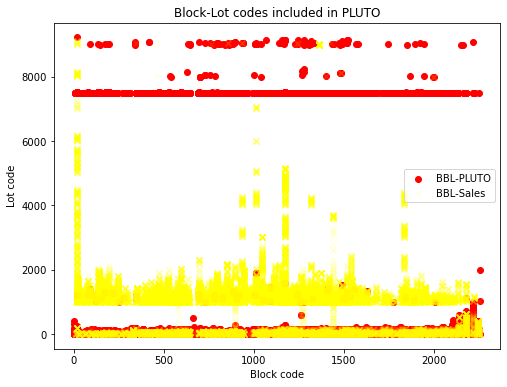

In [14]:
# Merge NYCOD and PLUTO
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pluto.block_pluto, pluto.lot_pluto, label='BBL-PLUTO', color='red')
plt.scatter(sales.block_sales, sales.lot_sales, label='BBL-Sales', color='yellow', alpha=0.1, marker='x')
plt.xlabel('Block code')
plt.ylabel('Lot code')
plt.title('Block-Lot codes included in PLUTO')
plt.legend()
plt.savefig('OUTPUT_visualizations/3.Borough-Lot coverage.png')
plt.show()

In [15]:
# join based on BBL
df_1 = sales.merge(pluto, how='left', left_on=['block_sales', 'lot_sales'], right_on=['block_pluto', 'lot_pluto'])

#join based on address
#isolate transactions that were not matched before
missed = df_1[df_1['latitude'].isna() == True].iloc[:,:10]
#clean address text
addresses = []
for i in missed.address_sales:
    addresses.append(i.split(',')[0])
missed['address_clean'] = addresses
#merge on address
df_2 = missed.merge(pluto, how='left', left_on=['address_clean'], right_on=['address_pluto'])

#quantify
df_1 = df_1[df_1.latitude.isna() == False].drop(columns=['address_sales', 'address_pluto'])
df_2 = df_2[df_2.latitude.isna() == False].drop(columns=['address_clean', 'address_sales', 'address_pluto'])

len_all = len(sales)
len_bbl = len(df_1)
len_add = len(df_2)

print('{} total sales'.format(len_all))
print('{} matched on BBL'.format(len_bbl))
print('{} matched on address'.format(len_add))
print('{} unmatched ({:.3f}% of total)'.format((len_all - len_bbl - len_add), (100*(len_all - len_bbl - len_add)/len_all)))

#final df
df = pd.concat((df_1, df_2), axis=0)
df = df.drop(columns=['block_sales', 'lot_sales', 'block_pluto', 'lot_pluto'])
df.columns.sort_values()
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)
print('shape of final df: {}'.format(df.shape))

df.to_csv('OUTPUT_cleandata/df_clean.csv')

88439 total sales
43754 matched on BBL
18507 matched on address
26178 unmatched (29.600% of total)
shape of final df: (62261, 19)


In [16]:
df = df.drop(columns=['block_pluto_x', 'block_pluto_y'])

In [17]:
df.columns

Index(['units_residential', 'units_commercial', 'year_sold', 'years_elapsed',
       'FAR', 'log_saleprice', 'latitude', 'longitude', 'yearalter1',
       'yearalter2', 'numbldgs', 'numfloors', 'BCR', 'bin_ltdheight',
       'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

# Merge in distance datasets

In [18]:
import pandas as pd

hospital = pd.read_csv('INPUT_distances/hospital.csv')
park = pd.read_csv('INPUT_distances/park.csv')
school = pd.read_csv('INPUT_distances/public_school.csv')
subway = pd.read_csv('INPUT_distances/subway.csv')
housing = pd.read_csv('INPUT_distances/affordable_housing.csv')
college = pd.read_csv('INPUT_distances/college_university.csv')
museum = pd.read_csv('INPUT_distances/museum.csv')

df['dist_park'] = park.iloc[:,-1:]
df['dist_subway'] = subway.iloc[:,-1:]
df['dist_hospital'] = hospital.iloc[:len(df), -1:]
df['dist_school'] = school.iloc[:len(df), -1:]
df['dist_housingdev'] = housing.iloc[:len(df), -1:]
df['dist_college'] = college.iloc[:len(df), -1:]
df['dist_museum'] = museum.iloc[:len(df), -1:]

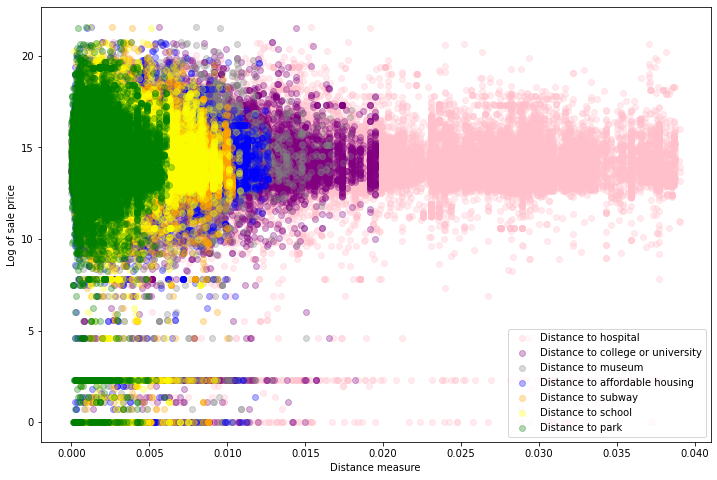

In [19]:
#visualize distribution of each 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.dist_hospital, df.log_saleprice, color='pink', alpha=0.3, label='Distance to hospital')
plt.scatter(df.dist_college, df.log_saleprice, color='purple', alpha=0.3, label='Distance to college or university')
plt.scatter(df.dist_museum, df.log_saleprice, color='gray', alpha=0.3, label='Distance to museum')
plt.scatter(df.dist_housingdev, df.log_saleprice, color='blue', alpha=0.3, label='Distance to affordable housing')
plt.scatter(df.dist_subway, df.log_saleprice, color='orange', alpha=0.3, label='Distance to subway')
plt.scatter(df.dist_school, df.log_saleprice, color='yellow', alpha=0.3, label='Distance to school')
plt.scatter(df.dist_park, df.log_saleprice, color='green', alpha=0.3, label='Distance to park')
plt.xlabel('Distance measure')
plt.ylabel('Log of sale price')
plt.legend()
plt.savefig('OUTPUT_visualizations/distances.png')
plt.show()

In [20]:
#check out columns with a lot of missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

print('Features with > 90% missing data: {} \n'.format(to_drop))
print('Features with any missing data:')
display(cols[cols['pct_missing']>0].sort_values('pct_missing', ascending=False))

Features with > 90% missing data: ['FAR'] 

Features with any missing data:


,column_name,pct_missing
4,FAR,90.372786
1,units_commercial,58.171247
0,units_residential,44.006682
17,dist_park,21.315109
18,dist_subway,21.315109
19,dist_hospital,21.315109
20,dist_school,21.315109
21,dist_housingdev,21.315109
22,dist_college,21.315109
23,dist_museum,21.315109


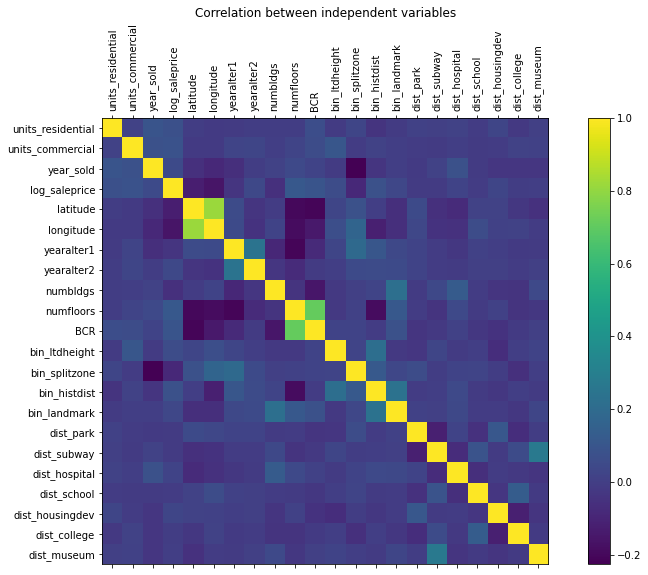

In [21]:
# plot corr matrix of all vars

f = plt.figure(figsize=(14, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation between independent variables')
plt.savefig('OUTPUT_visualizations/4.Corr matrix for all vars.png')
plt.show()

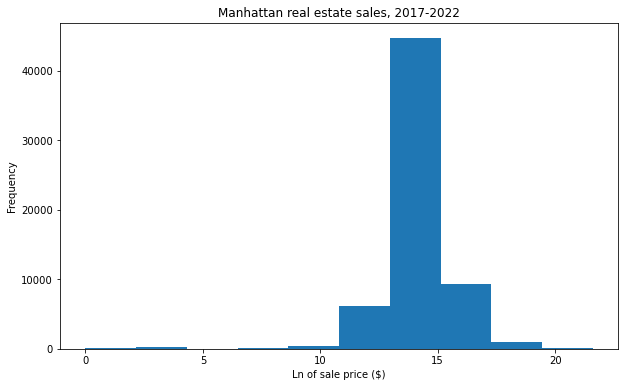

In [22]:
#plot hist of sale prices

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['log_saleprice'])
plt.xlabel('Ln of sale price ($)')
plt.ylabel('Frequency')
plt.title('Manhattan real estate sales, 2017-2022')
plt.savefig('OUTPUT_visualizations/5.Histogram of ln sale price.png')
plt.show()

In [23]:
df.describe()

,units_residential,units_commercial,year_sold,log_saleprice,latitude,longitude,yearalter1,yearalter2,numbldgs,numfloors,...,bin_splitzone,bin_histdist,bin_landmark,dist_park,dist_subway,dist_hospital,dist_school,dist_housingdev,dist_college,dist_museum
count,34862.000000,26043.000000,62261.000000,62261.000000,62261.000000,62261.000000,62260.000000,62260.000000,60083.000000,59387.000000,...,62261.000000,62261.000000,62261.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000,48990.000000
mean,3.610894,0.780709,2019.854355,14.010797,40.763062,-73.976272,994.473852,123.732862,1.348401,16.184426,...,0.963926,0.266106,0.028862,0.001543,0.003311,0.014357,0.002946,0.003044,0.006270,0.004947
std,22.340936,8.890122,1.791901,1.612630,0.033528,0.021197,995.873592,482.625043,2.142209,12.558037,...,0.186476,0.441924,0.167421,0.001117,0.001961,0.008534,0.001732,0.002132,0.003925,0.002836
min,0.000000,0.000000,2017.000000,0.000000,40.702776,-74.018118,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000155,0.000314,0.000013,0.000111,0.000001,0.000004
25%,0.000000,0.000000,2018.000000,13.342878,40.737678,-73.993485,0.000000,0.000000,1.000000,6.000000,...,1.000000,0.000000,0.000000,0.000629,0.001877,0.008505,0.001665,0.001389,0.003128,0.002651
50%,1.000000,0.000000,2020.000000,13.946539,40.763252,-73.978224,0.000000,0.000000,1.000000,14.000000,...,1.000000,0.000000,0.000000,0.001262,0.002859,0.011938,0.002613,0.002789,0.005528,0.004538
75%,1.000000,0.000000,2021.000000,14.731801,40.780653,-73.959475,1987.000000,0.000000,1.000000,20.000000,...,1.000000,1.000000,0.000000,0.002158,0.004227,0.018006,0.003794,0.004037,0.008882,0.007073
max,899.000000,570.000000,2022.000000,21.597693,40.878084,-73.909048,2021.000000,2021.000000,39.000000,98.000000,...,1.000000,1.000000,1.000000,0.006403,0.010516,0.039042,0.010841,0.012611,0.019470,0.017907


In [24]:
df.to_csv('OUTPUT_cleandata/df_dist.csv')